# Continuous Pendulum Control
Zero reward is the best condition for the pendulum control

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from env_pendulum import PendulumEnv

from itertools import count
import torch
import gym
from gym.envs.registration import register

import matplotlib
import matplotlib.pyplot as plt
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pendulum Control Gym

## Description
The inverted pendulum swingup problem is a classic problem in control theory. The system consists of a pendulum attached at one end to a fixed point, with the other end being free. The pendulum starts in a random position, and the goal is to apply torque to the free end to swing it into an upright position, where its center of gravity is right above the fixed point.

### Pendulum Coordinate System

- **x-y**: Cartesian coordinates of the pendulum’s end in meters.
- **theta**: Angle in radians.
- **tau**: Torque in N·m, defined as positive counter-clockwise.

### Action Space
The action is an ndarray with shape `(1,)` representing the torque applied to the free end of the pendulum.

| Num | Action | Min | Max |
|-----|--------|-----|-----|
| 0   | Torque | -2.0| 2.0 |

### Observation Space
The observation is an ndarray with shape `(3,)` representing the x-y coordinates of the pendulum’s free end and its angular velocity.

| Num | Observation      | Min | Max |
|-----|------------------|-----|-----|
| 0   | x = cos(theta)   | -1.0| 1.0 |
| 1   | y = sin(theta)   | -1.0| 1.0 |
| 2   | Angular Velocity | -8.0| 8.0 |

### Rewards
The reward function is defined as:

$r = -(theta^2 + 0.1 * theta_dt^2 + 0.001 * torque^2)$

where `theta` is the pendulum’s angle normalized between `[-pi, pi]` (with 0 being in the upright position). The minimum reward that can be obtained is `-(pi^2 + 0.1 * 8^2 + 0.001 * 2^2) = -16.2736044`, while the maximum reward is zero (pendulum is upright with zero velocity and no torque applied).

In [2]:
register(
    id='Pendulum-v0',
    entry_point='env_pendulum:PendulumEnv',
    max_episode_steps=1000)
env = gym.make('Pendulum-v0')

/Users/kevinb/anaconda3/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment Pendulum-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [3]:
env.action_space

Box(-2.0, 2.0, (1,), float32)

In [4]:
env.reward_range

(-inf, inf)

In [5]:
env.observation_space

Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)

Random actions stepping env

In [125]:
env = PendulumEnv(render_mode="human")
n_actions = env.action_space.shape[0]
state, info = env.reset()
n_observations = len(state)
num_eval_episodes = 10
for i_episode in range(num_eval_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        env.render()

        action = env.action_space.sample()  # This will generate a random action within the valid range
        observation, reward, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            print(f"Episode finished after {t+1} timesteps")
            break

        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
env.close()

#  DQN Agent Trained
Notice that due to the nature of DQN agent, it might be the best for it to operate in a discrete setting, the continuous version of the training may not be the most optimal training condition, so we discretize the action space of pendulum to a discrete condition.

Now, let\'s define our model. But first, let\'s quickly recap what a DQN
is.

DQN algorithm
=============

Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where $R_{t_0}$
is also known as the *return*. The discount, $\gamma$, should be a
constant between $0$ and $1$ that ensures the sum converges. A lower
$\gamma$ makes rewards from the uncertain far future less important for
our agent than the ones in the near future that it can be fairly
confident about. It also encourages agents to collect reward closer in
time than equivalent rewards that are temporally far away in the future.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell us
what our return would be, if we were to take an action in a given state,
then we could easily construct a policy that maximizes our rewards:

$$\pi^*(s) = \arg\!\max_a \ Q^*(s, a)$$

However, we don\'t know everything about the world, so we don\'t have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble $Q^*$.

For our training update rule, we\'ll use a fact that every $Q$ function
for some policy obeys the Bellman equation:

$$Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))$$

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

$$\delta = Q(s, a) - (r + \gamma \max_a' Q(s', a))$$

To minimize this error, we will use the [Huber
loss](https://en.wikipedia.org/wiki/Huber_loss). The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate this
over a batch of transitions, $B$, sampled from the replay memory:

$$\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)$$

$$\begin{aligned}
\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
  \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
  |\delta| - \frac{1}{2} & \text{otherwise.}
\end{cases}
\end{aligned}$$

Q-network
---------

Our model will be a feed forward neural network that takes in the
difference between the current and previous screen patches. It has two
outputs, representing $Q(s, \mathrm{left})$ and $Q(s, \mathrm{right})$
(where $s$ is the input to the network). In effect, the network is
trying to predict the *expected return* of taking each action given the
current input.

In [3]:
from dqn_discrete_train import main, load_model_and_evaluate
from dqn_continuous_train import main as con_main

/Users/kevinb/anaconda3/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment Pendulum-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/Users/kevinb/anaconda3/lib/python3.10/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment Pendulum-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Calling tarining loop for DQN continuous, nothing is learned

Complete


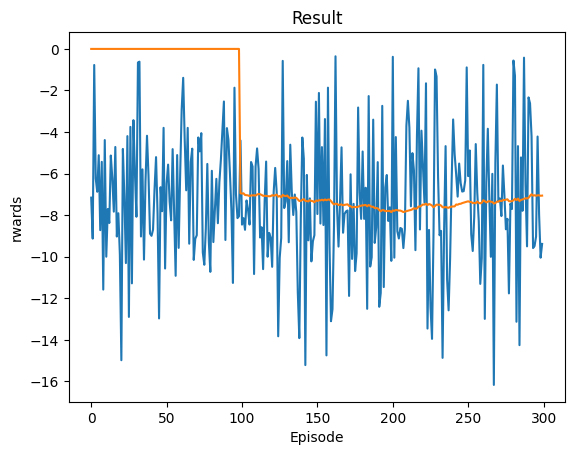

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [105]:
con_main()

Calling tarining loop for DQN discrete.

There are certain limits to the algorithm that you use: DQN may have limits performing in the continuous environments like pendulum, maybe the only way for it to perform well in the pendulum condition is to use discretization (classic problems faced in RL)

Complete


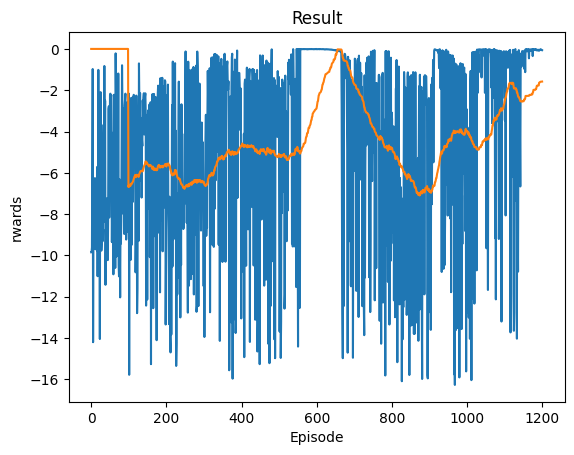

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [89]:
main()

Quite big of a flunctuation in training

# Conitual Training Using Previous Weights
Only loading in the policy network, not the rest of teh information

Complete


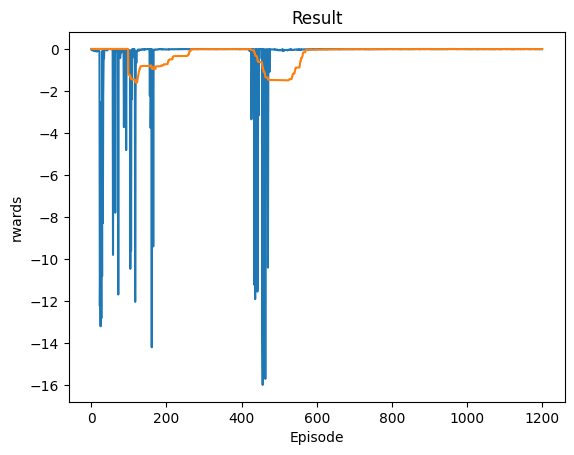

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [101]:
main('params/pendulum_dqn_discrete.pth')

# Evaluation of Model

In [5]:
from dqn_networks import DQN
import numpy as np

path = 'params/pendulum_dqn_discrete_retrain.pth'

env = PendulumEnv(render_mode="human")
ACTION_MAP = np.linspace(-2, 2, 5)  # 5 actions ranging from -2 to 2
n_actions = len(ACTION_MAP)
state, info = env.reset()
n_observations = len(state)

model = DQN(n_observations, n_actions).to(device)
model.load_state_dict(torch.load(path, map_location=device))
model.eval()

num_eval_episodes = 10
for i_episode in range(num_eval_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        env.render()

        action_idx = model(state).max(1)[1]
        actual_action = ACTION_MAP[action_idx.item()]

        observation, reward, terminated, truncated, _ = env.step([actual_action])
        if terminated or truncated:
            print(f"Episode finished after {t+1} timesteps")
            break

        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        
env.close()

# AGOP of DQN
Since DQN discretization, it is somewhat like an multi-class classification task now

In [3]:
from dqn_agop_train import PendulumControl
import torch.nn as nn
from dqn_networks import DQN
import numpy as np

## Calculate AGOP From Matrix (not useful)

In [4]:
register(
    id='Pendulum-v0',
    entry_point='env_pendulum:PendulumEnv',
    max_episode_steps=300)
env = gym.make('Pendulum-v0')

/Users/kevinb/anaconda3/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment Pendulum-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [5]:
ACTION_MAP = np.linspace(-2, 2, 5)  # 5 actions ranging from -2 to 2
n_actions = len(ACTION_MAP)
state, info = env.reset()
n_observations = len(state)

model = DQN(n_observations, n_actions).to(device)
model.load_state_dict(torch.load('params/pendulum_dqn_discrete_retrain.pth'))
model.eval()

DQN(
  (layer1): Linear(in_features=3, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=5, bias=True)
)

In [6]:
# Create dummy input based on the input size your network expects
dummy_input = torch.randn(1, n_observations, device=device)

# Create dummy target output for loss calculation
dummy_target = torch.randn(1, n_actions, device=device)

In [7]:
output = model(dummy_input)
loss_fn = nn.MSELoss()
loss = loss_fn(output, dummy_target)
model.zero_grad()
loss.backward()

In [8]:
average_outer_products = {}

# Compute the outer product of gradients for each parameter
for name, param in model.named_parameters():
    if param.grad is not None:
        grad = param.grad.view(-1)
        outer_product = torch.ger(grad, grad)

        # Aggregate outer products
        if name in average_outer_products:
            average_outer_products[name] += outer_product
        else:
            average_outer_products[name] = outer_product

# Average the outer products if necessary
for name, op in average_outer_products.items():
    average_outer_products[name] = op / len(average_outer_products)  # example averaging method
    print(f"{name}: {average_outer_products[name]}")

layer1.weight: tensor([[ 9.6231e+03, -1.8408e+05,  1.3263e+05,  ...,  2.3062e+02,
         -4.4116e+03,  3.1787e+03],
        [-1.8408e+05,  3.5212e+06, -2.5372e+06,  ..., -4.4116e+03,
          8.4388e+04, -6.0804e+04],
        [ 1.3263e+05, -2.5372e+06,  1.8281e+06,  ...,  3.1787e+03,
         -6.0804e+04,  4.3812e+04],
        ...,
        [ 2.3062e+02, -4.4116e+03,  3.1787e+03,  ...,  5.5270e+00,
         -1.0573e+02,  7.6179e+01],
        [-4.4116e+03,  8.4388e+04, -6.0804e+04,  ..., -1.0573e+02,
          2.0224e+03, -1.4572e+03],
        [ 3.1787e+03, -6.0804e+04,  4.3812e+04,  ...,  7.6179e+01,
         -1.4572e+03,  1.0500e+03]])
layer1.bias: tensor([[6.3667e+06, 0.0000e+00, 3.9203e+06,  ..., 7.3146e+06, 2.0287e+06,
         1.5258e+05],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.9203e+06, 0.0000e+00, 2.4139e+06,  ..., 4.5040e+06, 1.2491e+06,
         9.3952e+04],
        ...,
        [7.3146e+06, 0.0000e+00, 4.5

In [9]:
average_outer_products.keys()

dict_keys(['layer1.weight', 'layer1.bias', 'layer2.weight', 'layer2.bias', 'layer3.weight', 'layer3.bias'])

## Get Some Data from DQN

In [37]:
def collect_data_from_dqn(env, policy_net, episodes, steps_per_episode):
    states = []
    actions = []
    for _ in range(episodes):
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        for _ in range(steps_per_episode):
            action_index = policy_net(state).max(1)[1]
            actual_action = ACTION_MAP[action_index]
            observation, reward, terminated, truncated, _ = env.step([actual_action])
            states.append(state.squeeze())
            actions.append(actual_action)

            if terminated or truncated:
                print(f"Episode finished after {t+1} timesteps")
                break

        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    return states, actions

train_states, train_actions = collect_data_from_dqn(env, model, 50, 200)

In [38]:
train_states, train_actions = np.array([tensor.cpu().numpy() for tensor in train_states]), np.array(train_actions)

In [39]:
train_states.shape, train_actions.shape

((10000, 3), (10000,))

In [40]:
# controller = PendulumControl(average_outer_products, num_components=3)
# total_reward = controller.train_and_evaluate(train_states, train_actions)
# print(f"Total Reward from Controlled Run: {total_reward}")

In [41]:
test_size = 0.2 
X, y = train_states, train_actions

num_test_samples = int(len(X) * test_size)
indices = np.arange(len(X))
np.random.shuffle(indices)

test_indices = indices[:num_test_samples]
train_indices = indices[num_test_samples:]

train_X, train_y = X[train_indices], y[train_indices]
test_X, test_y = X[test_indices], y[test_indices]

In [42]:
from rfm import rfm

In [43]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

data_train = torch.from_numpy(train_X).float()
labels_train = torch.from_numpy(train_y).long()

data_test = torch.from_numpy(test_X).float()
labels_test = torch.from_numpy(test_y).long()

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

data_train = CustomDataset(data_train, labels_train)
data_test = CustomDataset(data_test, labels_test)

batch_size = 128
shuffle = True
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=shuffle)

In [44]:
train_loader

Notice that sometimes problem occurs because of the data format differences. For instance, data y here is using the shape (8000, 1) instead of shape of (8000) directly.

In [45]:
train_y = train_y.reshape([train_y.shape[0],1])
test_y = test_y.reshape([test_y.shape[0],1])

In [46]:
# M, _ = rfm.rfm(train_loader=train_loader, test_loader=test_loader, iters=2, loader=True, classif=True)

In [50]:
M, _ = rfm.rfm(train_loader=(train_X, train_y), test_loader=(test_X,test_y), iters=5, loader=False, classif=True)

Round 0 MSE:  2.9599944404181586e-08
Round 0 Acc:  1.0


100%|██████████| 4000/4000 [00:00<00:00, 38327.34it/s]


Round 1 MSE:  1.5690786100728188e-08
Round 1 Acc:  1.0


100%|██████████| 4000/4000 [00:00<00:00, 37630.41it/s]


Round 2 MSE:  4.174677138866516e-08
Round 2 Acc:  1.0


100%|██████████| 4000/4000 [00:00<00:00, 32595.54it/s]


Round 3 MSE:  4.023596240390803e-08
Round 3 Acc:  1.0


100%|██████████| 4000/4000 [00:00<00:00, 26280.72it/s]


Round 4 MSE:  3.1842473948794834e-08
Round 4 Acc:  1.0


100%|██████████| 4000/4000 [00:00<00:00, 29420.65it/s]


Final MSE:  2.5277833673697656e-08
 Final Acc:  1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


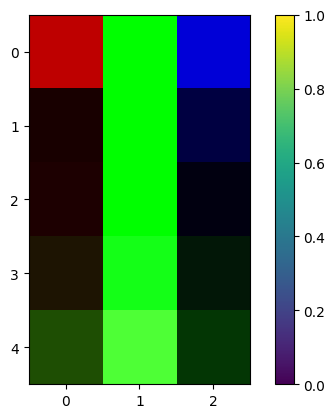

In [52]:
plt.imshow(M)
colorbar = plt.colorbar()

Test with random data

In [26]:
# define target function
def fstar(X):
    return (X[:, 0] * X[:, 1] * (X[:, 5] > 0))[:,None]

# create low rank data
n = 4000
d = 20
X_train = np.random.normal(scale=0.5, size=(n,d))
X_test = np.random.normal(scale=0.5, size=(n,d))

y_train = fstar(X_train)
y_test = fstar(X_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# run rfm
M, _ = rfm.rfm((X_train,y_train),(X_test,y_test), iters=5, loader=False, classif=False)

(4000, 20) (4000, 20) (4000, 1) (4000, 1)
Round 0 MSE:  0.010444202005884466


100%|██████████| 2000/2000 [00:00<00:00, 111775.08it/s]


Round 1 MSE:  0.004370979007499575


100%|██████████| 2000/2000 [00:00<00:00, 70011.25it/s]


Round 2 MSE:  0.0023196502850792193


100%|██████████| 2000/2000 [00:00<00:00, 44080.04it/s]


Round 3 MSE:  0.0018461104235133207


100%|██████████| 2000/2000 [00:00<00:00, 66567.27it/s]


Round 4 MSE:  0.0017143619605309703


100%|██████████| 2000/2000 [00:00<00:00, 94012.13it/s]


Final MSE:  0.0016761912182947092


In [30]:
y_train

array([[-0.00700417],
       [ 0.        ],
       [ 0.        ],
       ...,
       [-0.        ],
       [ 0.        ],
       [-0.        ]])